In [2]:
import os
import geopandas as gpd
import pandas as pd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

# 设置代理地址和端口
proxy_address = 'http://127.0.0.1:10890'

# 设置环境变量
os.environ['HTTP_PROXY'] = proxy_address
os.environ['HTTPS_PROXY'] = proxy_address

# 忽略警告信息
import warnings
warnings.filterwarnings('ignore')

# 设置绘图样式
%matplotlib inline
plt.style.use('ggplot')


In [3]:
# 读取Shapefile文件
gdf = gpd.read_file('./test_shp/hankou.shp')

# 确保坐标参考系为WGS84
gdf = gdf.to_crs(epsg=4326)

# 提取“Residential”多边形
residential_gdf = gdf[gdf['euluc_en'] == 'Residential'].copy()

# 定义目标类型列表（排除"Residential"和"Industrial"）
target_types = [
    "Business office",
    "Commercial service",
    "Transportation stations",
    "Administrative",
    "Educational",
    "Medical",
    "Sport and cultural",
    "Park and greenspace"
]

# 提取目标多边形，按类型分类
target_gdfs = {}
for t_type in target_types:
    target_gdf = gdf[gdf['euluc_en'] == t_type].copy()
    if not target_gdf.empty:
        target_gdfs[t_type] = target_gdf


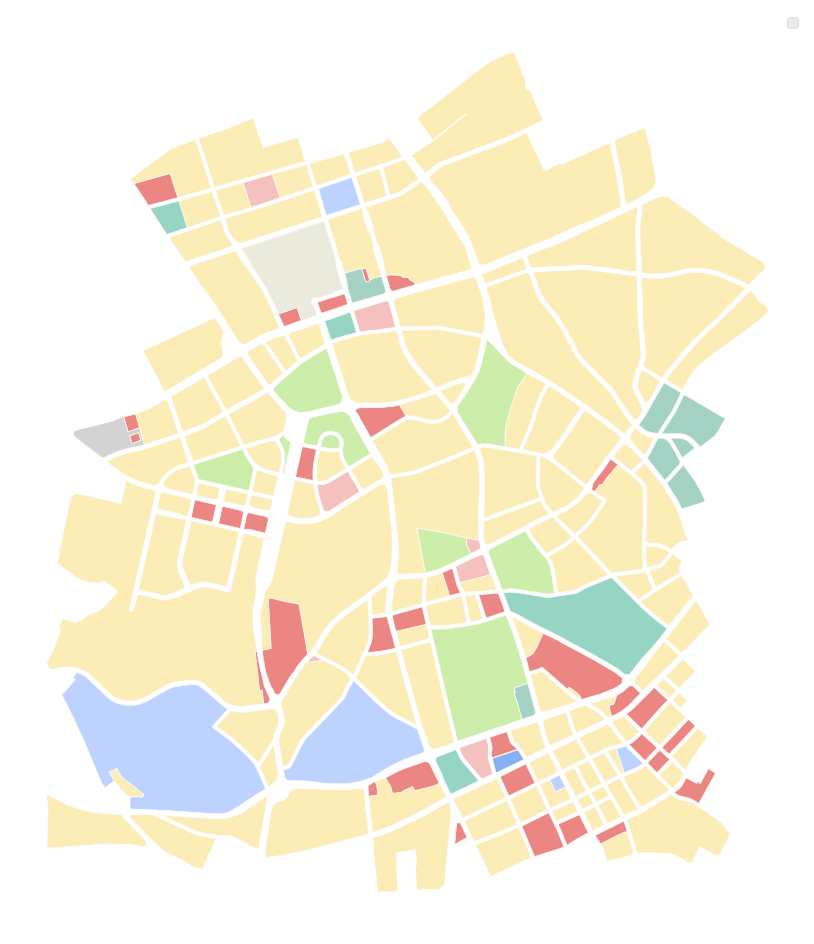

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置字体为Arial
rcParams['font.family'] = 'Arial'

# 创建一个绘图对象
fig, ax = plt.subplots(figsize=(12, 12))

# 绘制所有多边形
gdf.plot(ax=ax, color='lightgrey', edgecolor='white')

# 绘制“Residential”多边形
residential_gdf.plot(ax=ax, color='#fcecb6', edgecolor='white', label='Residential')

# 使用不同的颜色绘制各个目标类型的多边形
color_map = {
    'Residential': '#fcecb6',
    'Business office': '#f4c1bf',
    'Commercial service': '#eb8682',
    'Transportation stations': '#eaebdc',
    'Administrative': '#96d5c4',
    'Educational': '#bdd2ff',
    'Medical': '#a4d3c5',
    'Sport and cultural': '#87b0f2',
    'Park and greenspace': '#cdedab',
}

for idx, (t_type, target_gdf) in enumerate(target_gdfs.items()):
    target_gdf.plot(ax=ax, color=color_map[t_type], edgecolor='white', label=t_type)

# 添加图例
ax.legend()
# ax.set_title('Residential and Target Areas')
ax.axis('off')

# 保存为PDF格式，确保矢量化输出
plt.savefig('landuse.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()

In [7]:
# 计算“Residential”质心
residential_gdf['centroid'] = residential_gdf.geometry.centroid

# 计算目标类型质心
for t_type, target_gdf in target_gdfs.items():
    target_gdf['centroid'] = target_gdf.geometry.centroid
    target_gdfs[t_type] = target_gdf


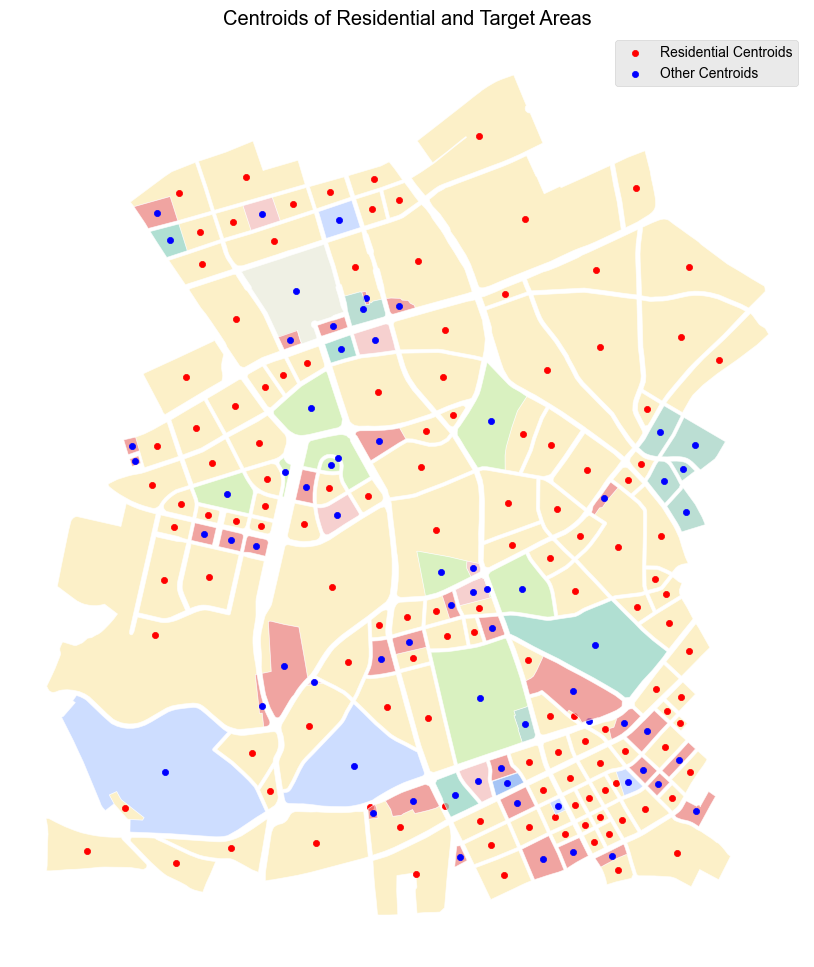

In [8]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置字体为Arial
rcParams['font.family'] = 'Arial'

# 创建一个绘图对象
fig, ax = plt.subplots(figsize=(12, 12))

# 绘制“Residential”多边形
residential_gdf.plot(ax=ax, color='#fcecb6', edgecolor='white', label='Residential', alpha=0.75)

# 绘制“Residential”质心
residential_gdf.centroid.plot(ax=ax, color='red', markersize=20, label='Residential Centroids')

# 绘制目标多边形和质心
for idx, (t_type, target_gdf) in enumerate(target_gdfs.items()):
    target_gdf.plot(ax=ax, color=color_map[t_type], edgecolor='white', label=t_type, alpha=0.75)
    target_gdf.centroid.plot(ax=ax, color='blue', markersize=20, label='Other Centroids')

# 获取当前图例的句柄和标签
handles, labels = ax.get_legend_handles_labels()

# 去重，保持顺序不变
unique_labels = dict(zip(labels, handles))

# 添加去重后的图例
ax.legend(unique_labels.values(), unique_labels.keys())

# 添加标题和关闭坐标轴
ax.set_title('Centroids of Residential and Target Areas')
ax.axis('off')

# 保存为PDF格式，确保矢量化输出
plt.savefig('centroid_plot.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()


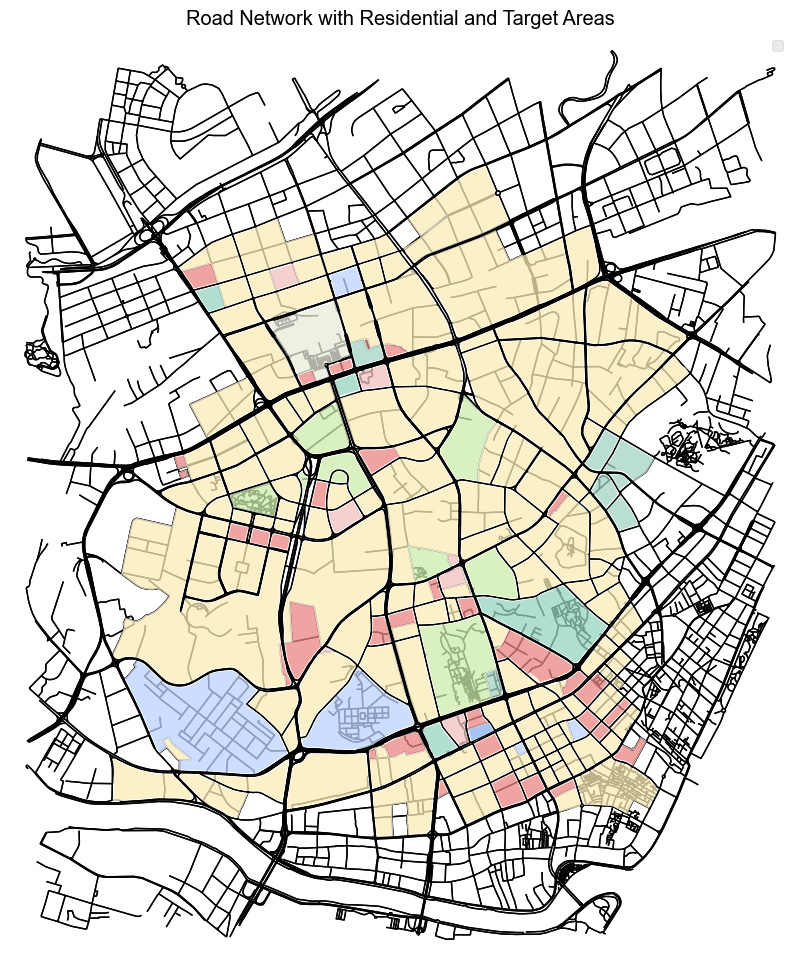

In [10]:
import matplotlib.pyplot as plt
import osmnx as ox
from matplotlib import rcParams

# 设置字体为Arial
rcParams['font.family'] = 'Arial'

# 计算研究区域的边界
minx, miny, maxx, maxy = gdf.total_bounds

# 添加缓冲区以覆盖边界外的区域
buffer = 0.01  # 可以调整缓冲区的大小
north, south, east, west = maxy + buffer, miny - buffer, maxx + buffer, minx - buffer

# 获取适用于步行的道路网络
G = ox.graph_from_bbox(north, south, east, west, network_type='walk')

# 创建绘图对象
fig, ax = plt.subplots(figsize=(12, 12))

# 绘制道路网络
ox.plot_graph(G, ax=ax, node_size=0, edge_color='black', show=False, close=False)

# 绘制“Residential”多边形
residential_gdf.plot(ax=ax, color='#fcecb6', alpha=0.75, edgecolor='white', label='Residential')

# 绘制目标多边形
for idx, (t_type, target_gdf) in enumerate(target_gdfs.items()):
    target_gdf.plot(ax=ax, color=color_map[t_type], alpha=0.75, edgecolor='white', label=t_type)

# 获取当前图例的句柄和标签
handles, labels = ax.get_legend_handles_labels()

# 去重，保持顺序不变
unique_labels = dict(zip(labels, handles))

# 添加去重后的图例
ax.legend(unique_labels.values(), unique_labels.keys())

# 添加标题并关闭坐标轴
ax.set_title('Road Network with Residential and Target Areas')
ax.axis('off')

# 保存为PDF格式，确保矢量化输出
plt.savefig('road_network_plot.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()


In [11]:
# 为每条边添加长度（如果尚未添加）
G = ox.distance.add_edge_lengths(G)

# 设置平均步行速度（米/秒），例如4.8 km/h
walking_speed_mps = 4.8 / 3.6  # 转换为米/秒

# 计算每条边的旅行时间
for u, v, data in G.edges(data=True):
    data['travel_time'] = data['length'] / walking_speed_mps

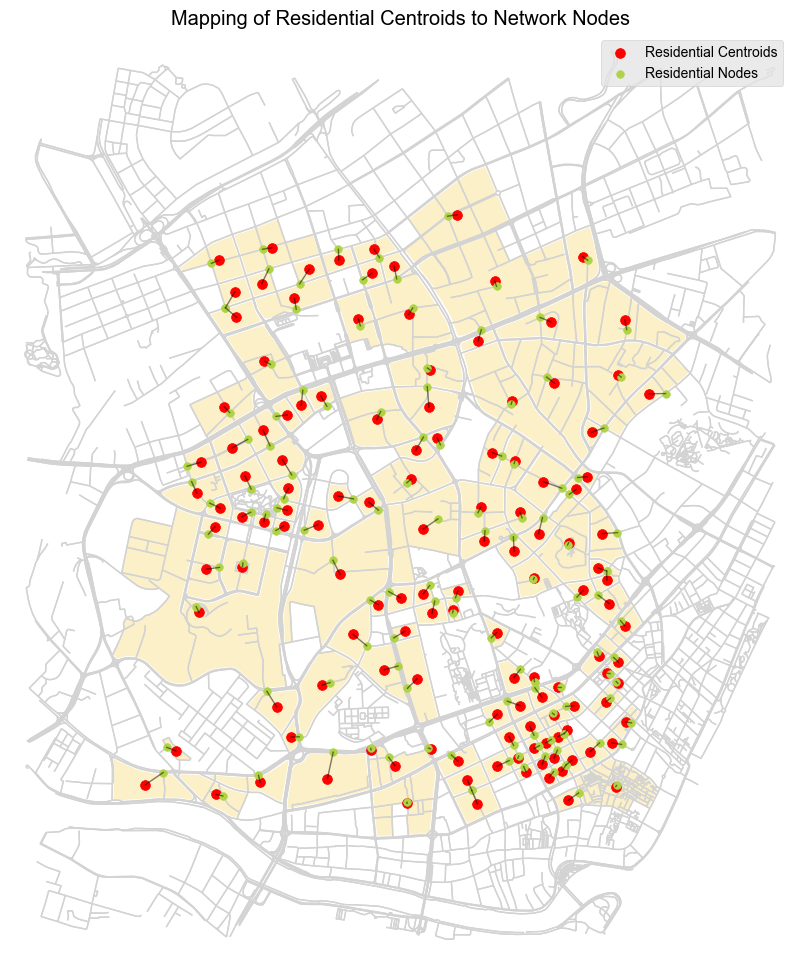

In [12]:
import matplotlib.pyplot as plt
import osmnx as ox
from matplotlib import rcParams

# 设置字体为Arial
rcParams['font.family'] = 'Arial'

# 为“Residential”质心找到最近的节点
residential_gdf['node'] = residential_gdf['centroid'].apply(
    lambda point: ox.distance.nearest_nodes(G, X=point.x, Y=point.y)
)

# 为每个目标类型的质心找到最近的节点
for t_type, target_gdf in target_gdfs.items():
    target_gdf['node'] = target_gdf['centroid'].apply(
        lambda point: ox.distance.nearest_nodes(G, X=point.x, Y=point.y)
    )
    target_gdfs[t_type] = target_gdf

# 获取节点的坐标
residential_nodes = G.nodes
residential_gdf['node_x'] = residential_gdf['node'].apply(lambda n: residential_nodes[n]['x'])
residential_gdf['node_y'] = residential_gdf['node'].apply(lambda n: residential_nodes[n]['y'])

for t_type, target_gdf in target_gdfs.items():
    target_nodes = G.nodes
    target_gdf['node_x'] = target_gdf['node'].apply(lambda n: target_nodes[n]['x'])
    target_gdf['node_y'] = target_gdf['node'].apply(lambda n: target_nodes[n]['y'])
    target_gdfs[t_type] = target_gdf

# 创建绘图对象
fig, ax = plt.subplots(figsize=(12, 12))

# 绘制“Residential”多边形
residential_gdf.plot(ax=ax, color='#fcecb6', alpha=0.75, edgecolor='white', label='Residential')

# 绘制道路网络
ox.plot_graph(G, ax=ax, node_size=0, edge_color='lightgrey', show=False, close=False)

# 绘制“Residential”质心和对应的节点
ax.scatter(residential_gdf['centroid'].x, residential_gdf['centroid'].y, color='red', label='Residential Centroids', s=50)
ax.scatter(residential_gdf['node_x'], residential_gdf['node_y'], color='#b0d345', label='Residential Nodes', s=30)

# 绘制连接线
for idx, row in residential_gdf.iterrows():
    x_values = [row['centroid'].x, row['node_x']]
    y_values = [row['centroid'].y, row['node_y']]
    ax.plot(x_values, y_values, color='black', linewidth=1, alpha=0.5)

# 获取当前图例的句柄和标签
handles, labels = ax.get_legend_handles_labels()

# 去重，保持顺序不变
unique_labels = dict(zip(labels, handles))

# 添加去重后的图例
ax.legend(unique_labels.values(), unique_labels.keys())

# 添加标题并关闭坐标轴
ax.set_title('Mapping of Residential Centroids to Network Nodes')
ax.axis('off')

# 保存为PDF格式，确保矢量化输出
plt.savefig('centroid_node_mapping.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()


In [13]:
res_id = 130

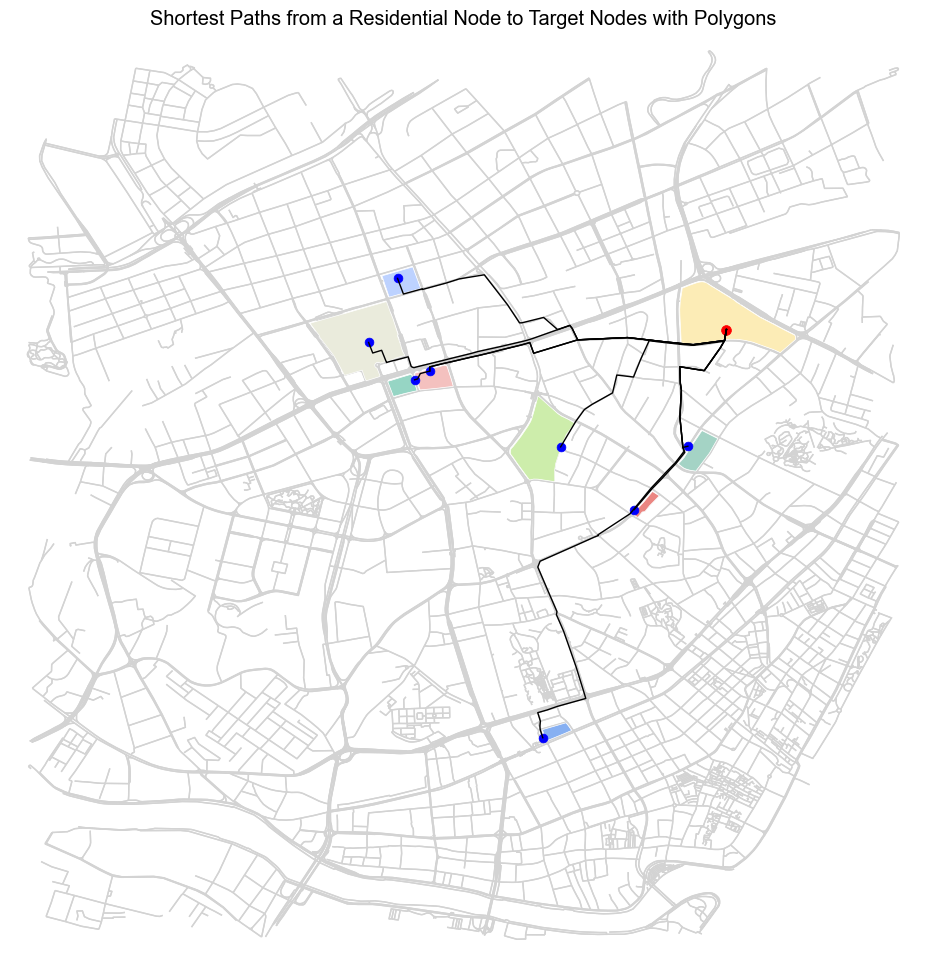

In [15]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import geopandas as gpd
from matplotlib import rcParams

# 设置字体为Arial
rcParams['font.family'] = 'Arial'

# 选择一个“Residential”节点及其对应的多边形
sample_residential = residential_gdf.iloc[res_id]
source_node = sample_residential['node']

# 获取源多边形
source_polygon = sample_residential['geometry']

# 创建绘图对象
fig, ax = plt.subplots(figsize=(12, 12))

# 绘制道路网络
ox.plot_graph(G, ax=ax, node_size=0, edge_color='lightgrey', show=False, close=False)

# 绘制源多边形
gpd.GeoSeries([source_polygon]).plot(ax=ax, color='#fcecb6', alpha=1, edgecolor='white')

# 绘制源节点
ax.scatter(sample_residential['node_x'], sample_residential['node_y'], color='red', s=50, label='Residential Node')

# 标记是否已经绘制过某个目标类型的区域和节点，以避免重复图例
area_labels_drawn = set()
node_labels_drawn = set()
path_labels_drawn = set()

# 对于每个目标类型，绘制到最近目标节点的最短路径，并绘制目标多边形
for idx, (t_type, target_gdf) in enumerate(target_gdfs.items()):
    target_nodes = target_gdf['node'].tolist()
    
    # 计算到所有目标节点的最短路径长度
    lengths = nx.single_source_dijkstra_path_length(G, source_node, weight='travel_time')
    
    # 找到最近的目标节点
    target_nodes_in_lengths = [node for node in target_nodes if node in lengths]
    if not target_nodes_in_lengths:
        continue
    nearest_target_node = min(target_nodes_in_lengths, key=lambda node: lengths[node])
    
    # 获取目标节点所在的多边形
    target_row = target_gdf[target_gdf['node'] == nearest_target_node].iloc[0]
    nearest_target_polygon = target_row['geometry']
    
    # 获取目标节点坐标
    target_x = G.nodes[nearest_target_node]['x']
    target_y = G.nodes[nearest_target_node]['y']
    
    # 绘制目标多边形
    area_label = None
    if t_type not in area_labels_drawn:
        area_label = f'{t_type} Area'
        area_labels_drawn.add(t_type)
    gpd.GeoSeries([nearest_target_polygon]).plot(ax=ax, color=color_map[t_type], alpha=1, edgecolor='white', label=area_label)
    
    # 绘制目标节点
    node_label = None
    if t_type not in node_labels_drawn:
        node_label = f'{t_type} Node'
        node_labels_drawn.add(t_type)
    ax.scatter(target_x, target_y, color="blue", s=40, label=node_label)
    
    # 计算最短路径
    path = nx.shortest_path(G, source_node, nearest_target_node, weight='travel_time')
    
    # 获取路径的坐标
    path_coords = [(G.nodes[node]['x'], G.nodes[node]['y']) for node in path]
    xs, ys = zip(*path_coords)
    path_label = None
    if t_type not in path_labels_drawn:
        path_label = f'Path to {t_type}'
        path_labels_drawn.add(t_type)
    ax.plot(xs, ys, color="black", linewidth=1, alpha=1, label=path_label)
    
# 获取当前图例的句柄和标签
handles, labels = ax.get_legend_handles_labels()

# 去重，保持顺序不变
unique_labels = dict(zip(labels, handles))

# 添加去重后的图例
# ax.legend(unique_labels.values(), unique_labels.keys())

# 添加标题并关闭坐标轴
ax.set_title('Shortest Paths from a Residential Node to Target Nodes with Polygons')
ax.axis('off')

# 保存为PDF格式，确保矢量化输出
plt.savefig('shortest_paths_to_targets.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()


In [16]:
# 初始化结果字典
average_travel_times = {}

# 对于每个目标类型，计算平均旅行时间
for t_type, target_gdf in target_gdfs.items():
    print(f"Calculating average travel time to {t_type}...")
    
    # 获取目标节点集合
    target_nodes_set = set(target_gdf['node'].unique())
    
    # 定义函数计算平均旅行时间
    def compute_average_travel_time(G, source_node, target_nodes_set):
        # 使用Dijkstra算法计算从源节点到所有可达节点的最短路径长度
        lengths = nx.single_source_dijkstra_path_length(G, source_node, weight='travel_time')
    
        # 提取到目标节点的旅行时间
        travel_times = [lengths[node] for node in target_nodes_set if node in lengths]
    
        if travel_times:
            average_time = sum(travel_times) / len(travel_times)
            return average_time
        else:
            return None  # 没有找到路径
    
    # 对每个“Residential”节点计算平均旅行时间
    residential_gdf[f'avg_time_to_{t_type}'] = residential_gdf['node'].apply(
        lambda node: compute_average_travel_time(G, node, target_nodes_set)
    )
    
    # 将旅行时间从秒转换为分钟
    residential_gdf[f'avg_time_to_{t_type}_minutes'] = residential_gdf[f'avg_time_to_{t_type}'] / 60.0
    
    # 处理缺失值
    residential_gdf[f'avg_time_to_{t_type}_minutes'] = residential_gdf[f'avg_time_to_{t_type}_minutes'].fillna(-1)
    
    # 保存结果
    average_travel_times[t_type] = residential_gdf[f'avg_time_to_{t_type}_minutes']

Calculating average travel time to Business office...
Calculating average travel time to Commercial service...
Calculating average travel time to Transportation stations...
Calculating average travel time to Administrative...
Calculating average travel time to Educational...
Calculating average travel time to Medical...
Calculating average travel time to Sport and cultural...
Calculating average travel time to Park and greenspace...


In [17]:
# 计算到所有目标类型的总体平均旅行时间
def compute_overall_average(row):
    times = []
    for t_type in target_types:
        column_name = f'avg_time_to_{t_type}_minutes'
        time = row.get(column_name, None)
        if time is not None and time != -1:
            times.append(time)
    if times:
        return sum(times) / len(times)
    else:
        return None

residential_gdf['overall_average_travel_time_minutes'] = residential_gdf.apply(compute_overall_average, axis=1)


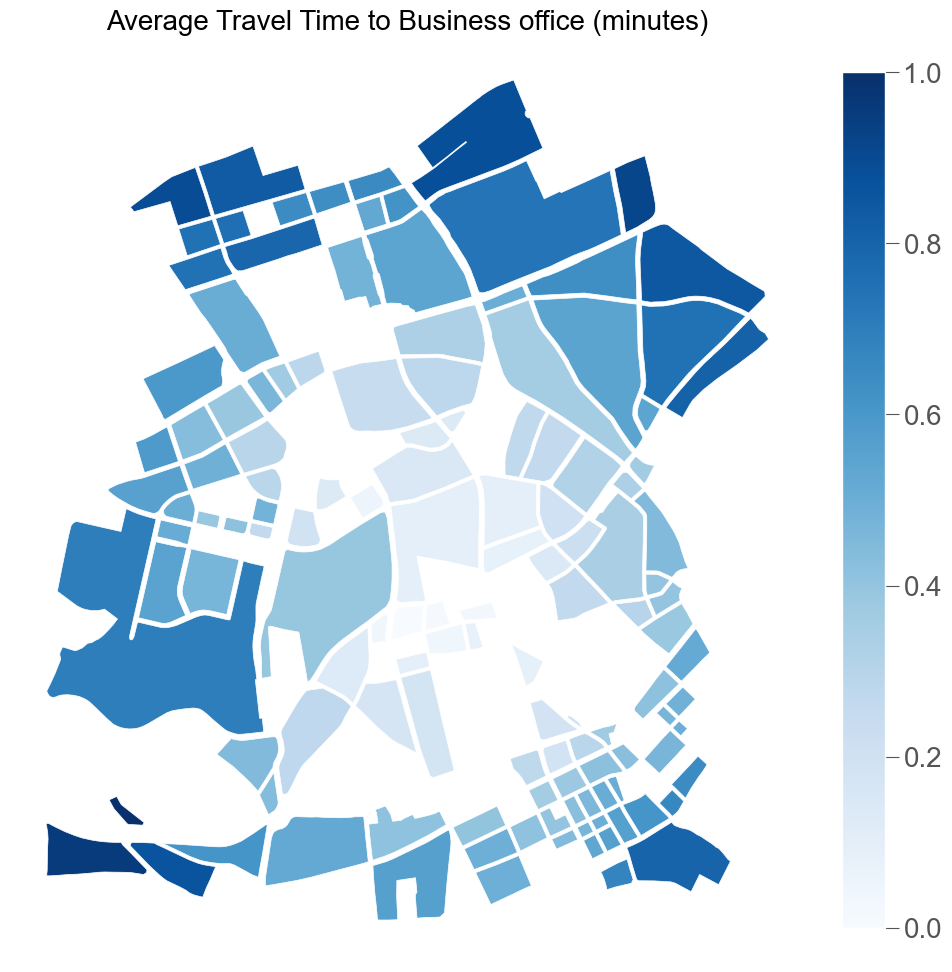

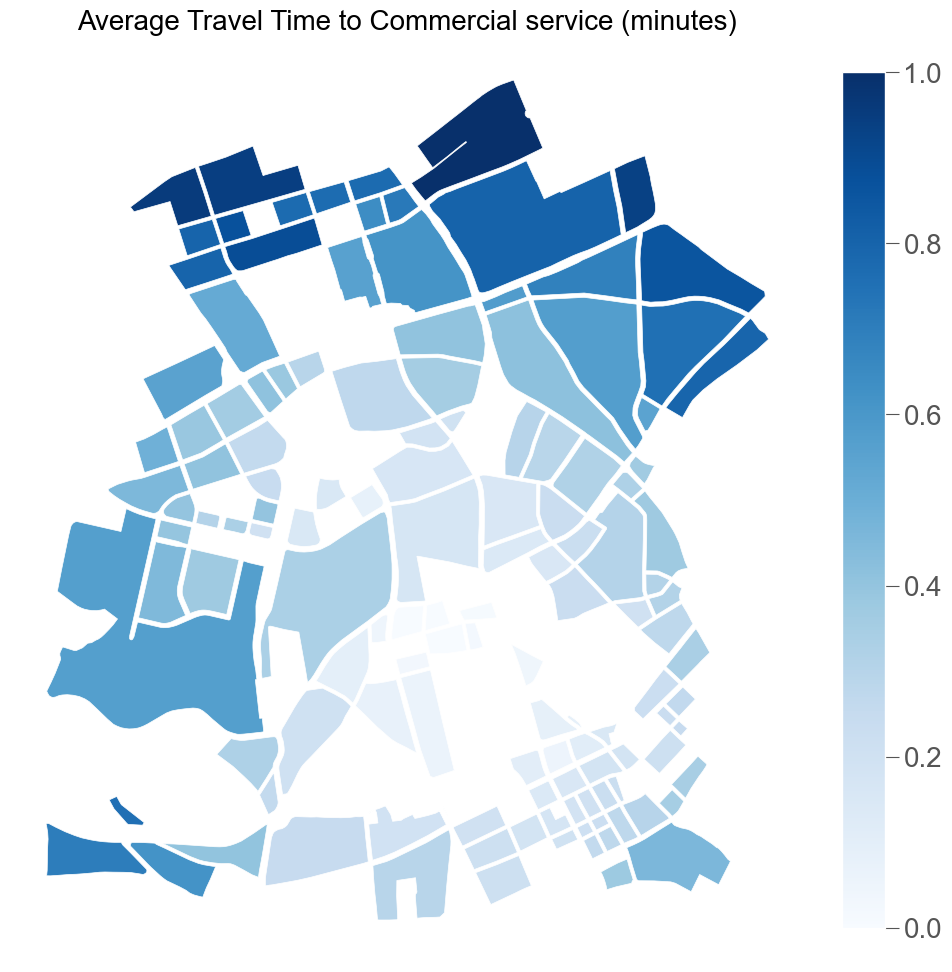

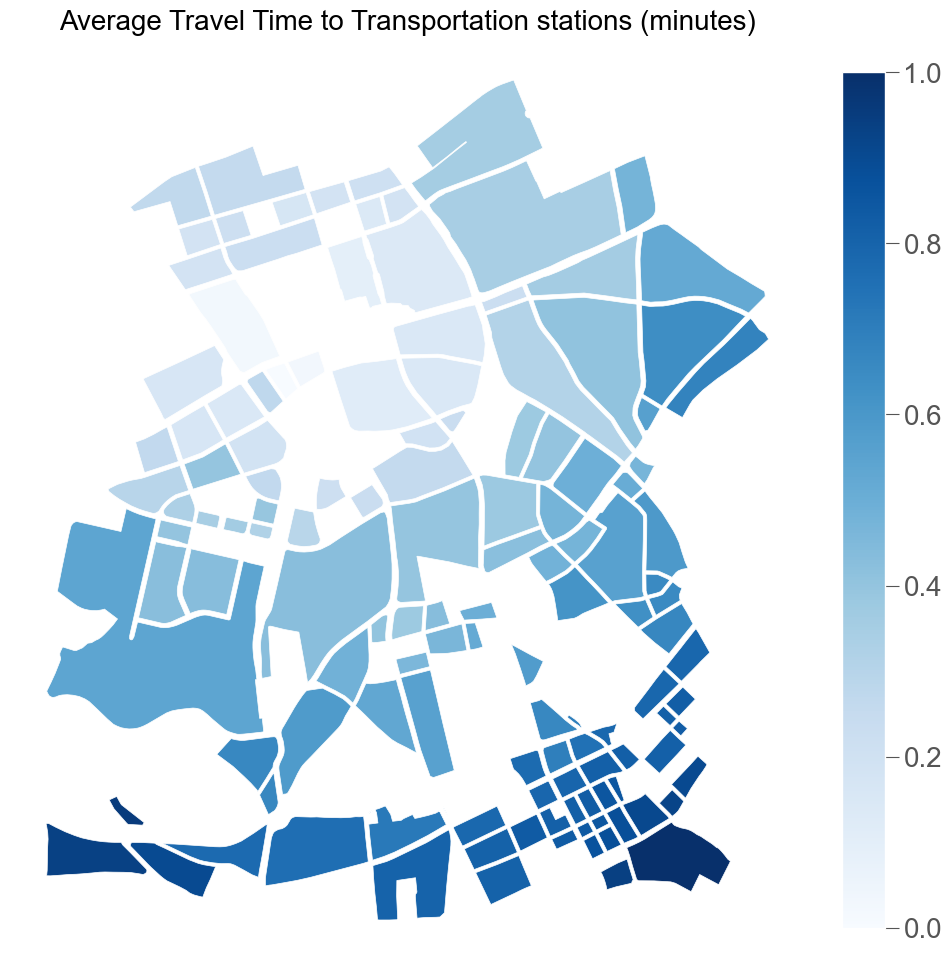

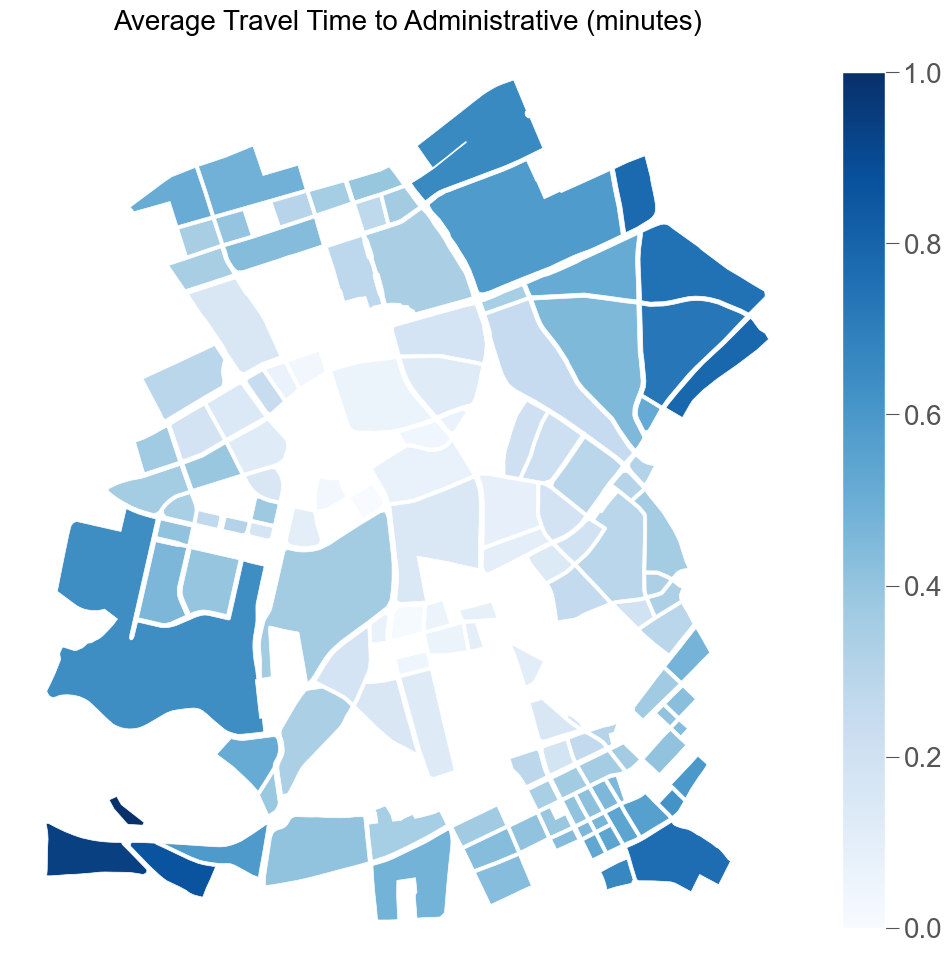

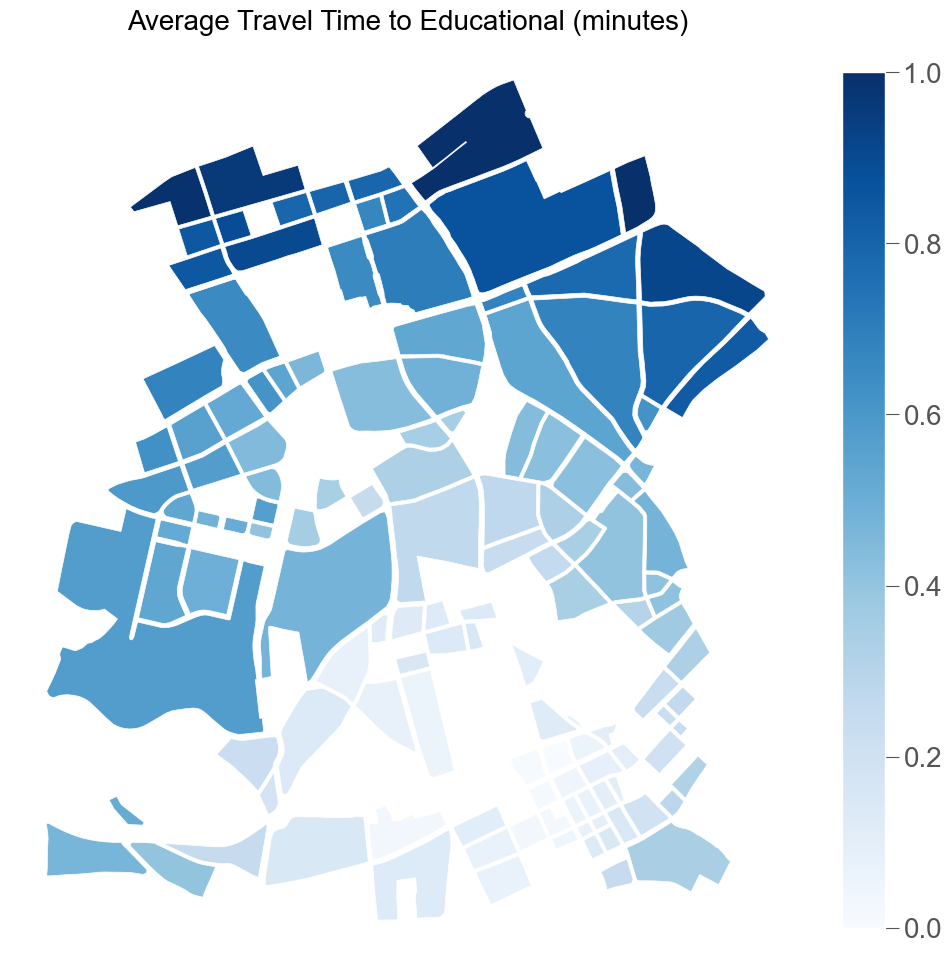

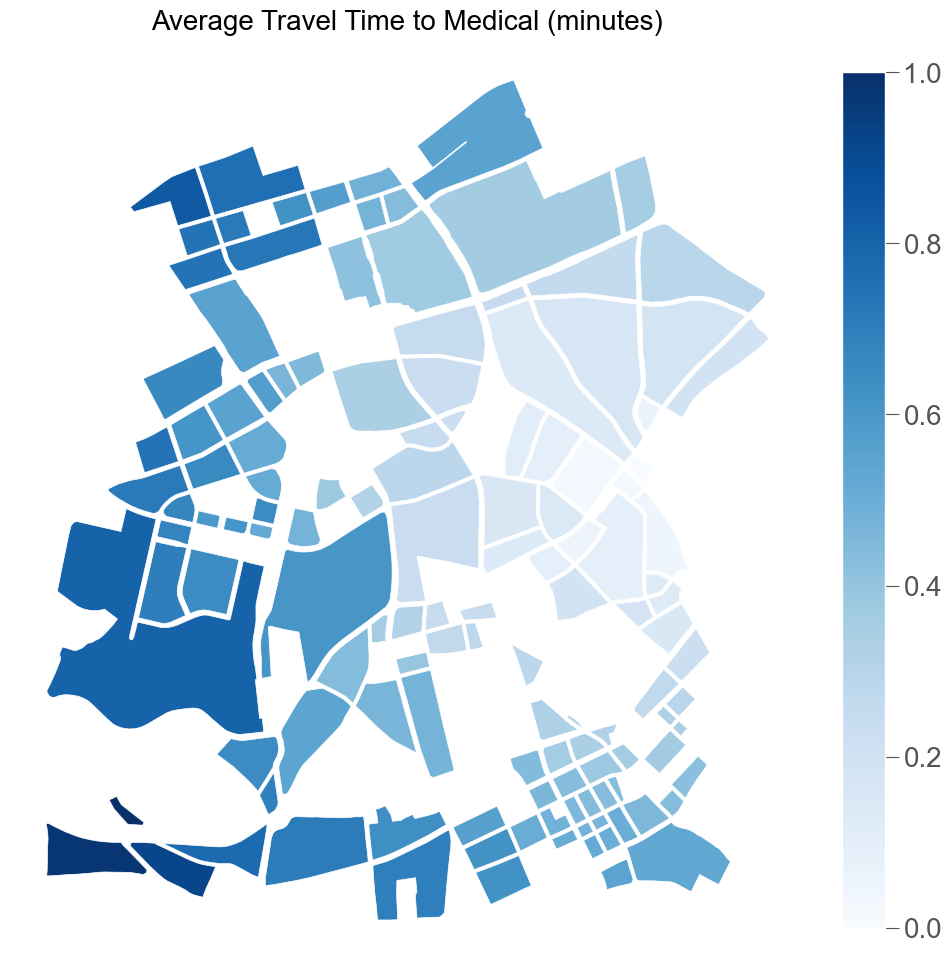

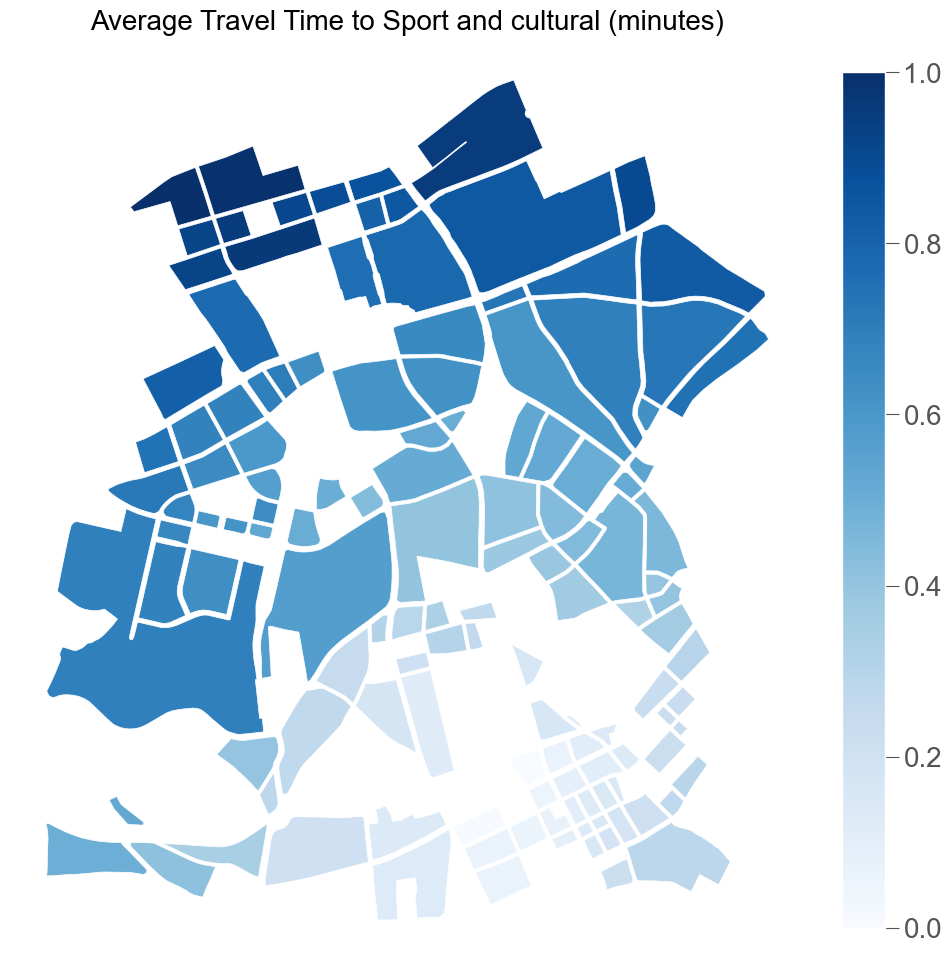

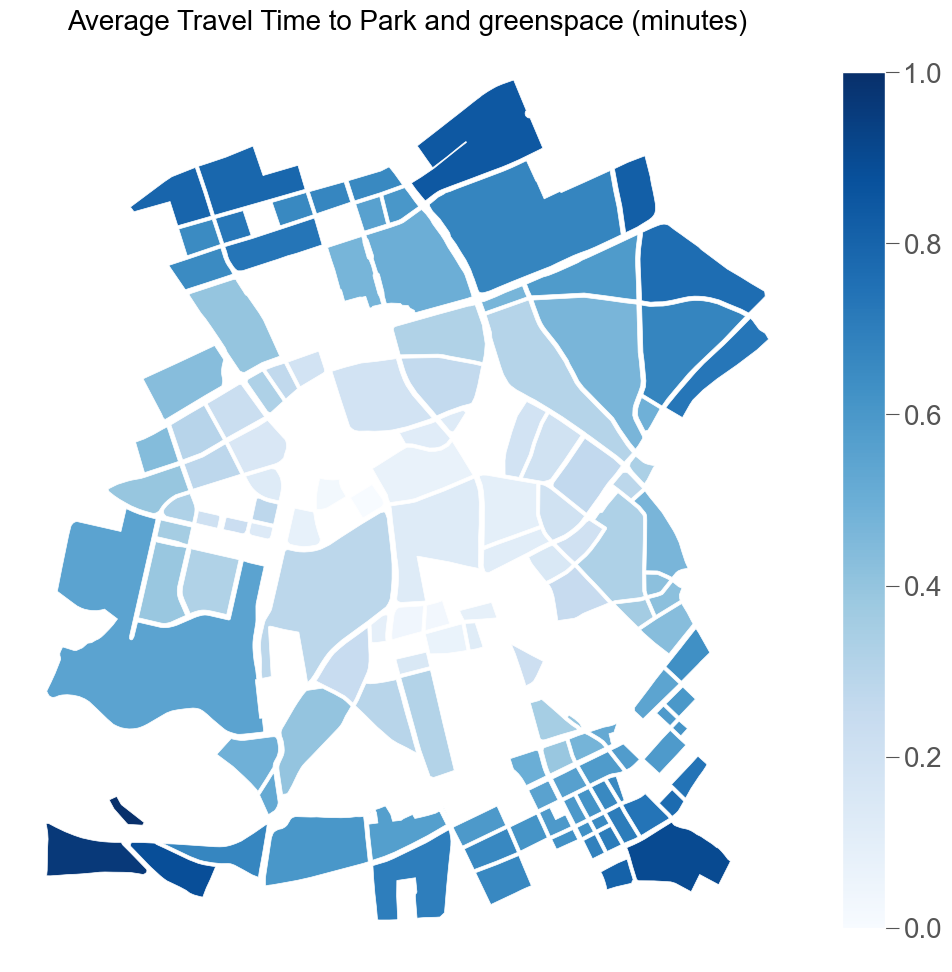

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# 设置字体为Arial
rcParams['font.family'] = 'Arial'

# 设置更淡的颜色映射（例如，选择 'YlGnBu'）
cmap = 'Blues'

for idx, t_type in enumerate(target_types):
    column_name = f'avg_time_to_{t_type}_minutes'
    
    if column_name in residential_gdf.columns:
        fig, ax = plt.subplots(figsize=(12, 12))
        
        # 绘制地图
        residential_gdf.plot(column=column_name, ax=ax, cmap=cmap, edgecolor='white')
        
        # 设置标题和字体大小
        ax.set_title(f'Average Travel Time to {t_type} (minutes)', fontsize=20)
        
        # 获取图像的位置
        position = ax.get_position()
        # 创建colorbar，并手动调整其大小和位置
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array([])  # 没有数组，因为我们直接从Geopandas绘制
        cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)  # 调整fraction和pad
        cbar.ax.tick_params(labelsize=20, length=10)  # 设置刻度大小和刻度线长度
        
        # 隐藏坐标轴
        ax.axis('off')
        
        # 保存为PDF矢量格式
        plt.savefig(f'avg_travel_time_to_{t_type}.pdf', format='pdf', bbox_inches='tight')
        
        # 显示图形
        plt.show()


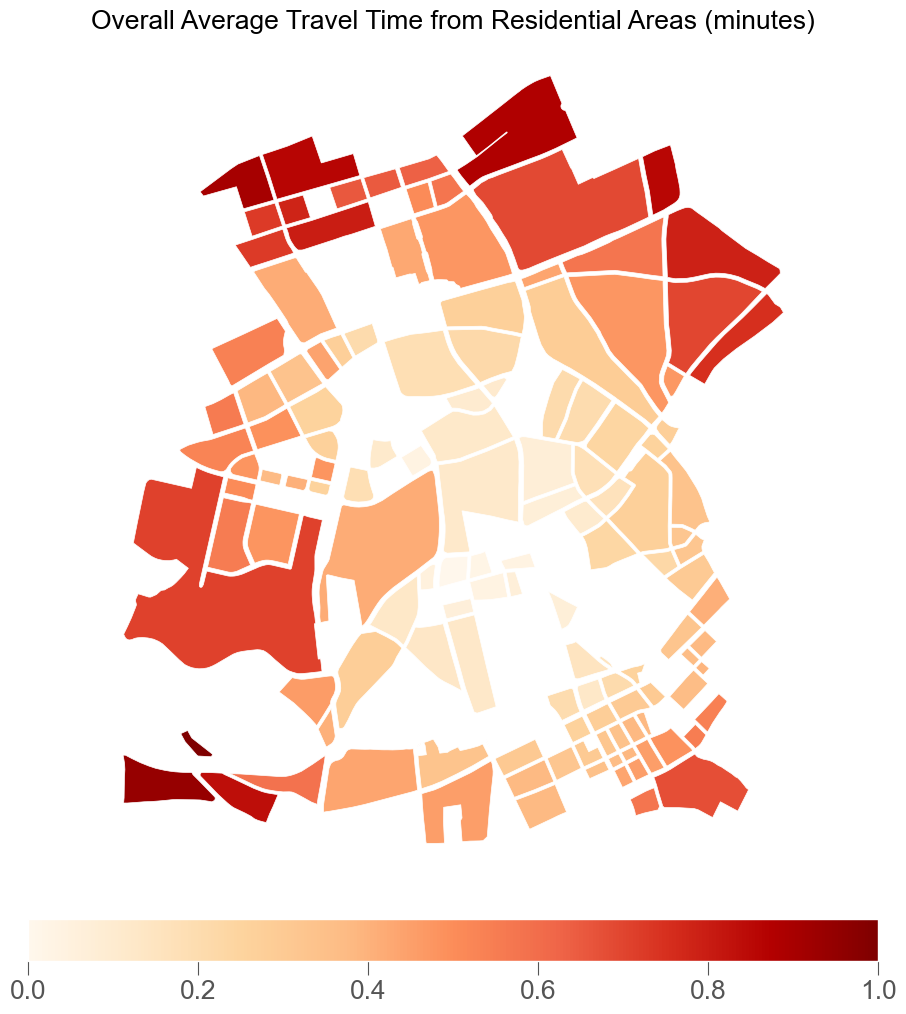

In [41]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# 设置字体为Arial
rcParams['font.family'] = 'Arial'

# 设置颜色映射
cmap = 'OrRd'
# 创建绘图对象
fig, ax = plt.subplots(figsize=(12, 12))

# 绘制住宅区的平均出行时间地图
residential_gdf.plot(column='overall_average_travel_time_minutes', ax=ax, cmap=cmap, edgecolor='white')

# 设置标题和字体大小
ax.set_title('Overall Average Travel Time from Residential Areas (minutes)', fontsize=19)

# 创建colorbar，设置其在底部水平放置
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])  # 没有数组，因为我们直接从Geopandas绘制
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, orientation='horizontal')  # 设置为水平放置
cbar.ax.tick_params(labelsize=19, length=10)  # 设置刻度字体大小和刻度线长度

# 隐藏坐标轴
ax.axis('off')
# 保存为PDF矢量格式
plt.savefig('overall_avg_travel_time_horizontal_cbar.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()




In [17]:
# 保存结果到新的Shapefile或Feather文件
residential_gdf.to_feather("residential_average_travel_times.feather")